In [1]:
library(tidyverse)
library(patchwork)
source("/shareb/zliu//analysis/hires_gastrulation/CHARMtools/Rlibs/plotFun.R")
source("/shareb/zliu//analysis/hires_gastrulation/CHARMtools/Rlibs/compartment_ana.R")
library(Seurat)
library(GGally)
library(ComplexHeatmap)

── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Registered S3 method overwritten by 'spatstat.geom':
  method     from
  print.boxx cli 

Attaching SeuratObject

Registered S3 method overwritten by 'GGally'

In [2]:
celltypeColors = c(
"mitosis"="#bebebe","blood"="#ff9400",
"ExE endoderm"="#fec44f", "ExE ectoderm"="#cab2d6","early neurons"="#1F62A6", "mix late mesenchyme"="#BD342F",
"epiblast and PS"="#addd8e",
#neural
"neural ectoderm"="#AECBE6","NMP"="#96B9DB","neural tube"="#7EA8D0","notochord"="#6696C6","radial glias"="#4F85BB","oligodendrocytes and progenitors"="#3773B1","schwann cell precursors"="#08519C",
#mesodermal
"early mesoderm"="#FC9272","ExE mesoderm"="#EF7F64","early mesenchyme"="#E36C57","intermediate mesoderm"="#D6594A", "myocytes"="#CA473C",
"endoderm"="#fe9929","epithelial cells"="#fa9fb5")

cellcyclecolors = c("G0"="#762a83","G1"="#c2a5cf","Early-S"="#99d8c9","Mid-S"="#66c2a4","Late-S"="#41ae76","G2"="#238b45","M"="#ea6e34")

In [3]:
hires <- readRDS("/shareb/zliu//analysis/hires_mouse_dev/hires_mouse_emb_dev.new.rds")

In [4]:
read_compartment <- function(lineage){
    path = paste0("/shareb/zliu//analysis/hires_mouse_dev/figure3_related/pileup/processed/compartment/",lineage,".compartment.100k.cis.vecs.tsv")
    return(read_table(path) %>% mutate(lineage = lineage))
}

In [5]:
celltypes <- hires[[]] %>% pull(celltype) %>% unique() %>% str_replace_all(" ","_")
combine <-  (bind_rows(map(celltypes,read_compartment)) %>% mutate(compartment = ifelse(E1<=0,"B","A")) %>% na.omit()) %>% suppressWarnings() %>% suppressMessages()
combine <- combine %>% filter(lineage != "mitosis")  %>% filter(chrom %in% paste0("chr",seq(1:19)))

In [19]:
pubReady <- function(p)
{
    # remove axis title for ggplot object
    library(ggthemes)
    p + theme_void(base_size = 15) + theme(title = element_blank())
}

In [113]:
metadata <- hires[[]]
lev2num <- function(str){
    return(which(c("E70","E75","E80","E85","E95","EX05","EX15") == str))
}

metadata <- metadata %>% group_by(stage) %>% sample_n(size = 500,replace = T) %>% filter(celltype != "mitosis") %>% 
group_by(celltype,stage) %>% summarise(count = n()) %>% group_by(celltype) %>% mutate(count = count / sum(count)) %>% filter(celltype != "mitosis")
#celltype_orders <- metadata %>% group_by(celltype) %>% arrange(celltype,stage) %>% rowwise() %>% mutate(order = lev2num(stage) * count) %>%
#                            group_by(celltype) %>% summarise(order = sum(order)) %>% arrange(order) %>% pull(celltype)\
celltype_orders <- c("epiblast and PS","ExE endoderm","ExE ectoderm","ExE mesoderm","blood","endoderm","neural ectoderm",
                        "early mesoderm","epithelial cells","early mesenchyme","NMP","neural tube","schwann cell precursors",
                        "notochord","intermediate mesoderm","radial glias","oligodendrocytes and progenitors","mix late mesenchyme","early neurons","myocytes")

combine$lineage <- factor(combine$lineage,levels = celltype_orders %>% str_replace_all(" ","_"))
metadata$celltype <- factor(metadata$celltype,levels = celltype_orders)
p <- metadata %>% ggplot() + geom_point(aes(x=0,y=0,size=count,color = celltype)) + facet_grid(celltype~stage) + theme_classic() + scale_color_manual(values = celltypeColors)  + guides(color = "none")

p <- pubReady(p) + guides(color = "none")

q <- combine %>% filter(chrom=="chr7",lineage != "mitosis") %>% na.omit() %>%  mutate(E1 = ifelse(E1>1,1,E1), E1 = ifelse(E1<(-1),-1,E1)) %>% ggplot(aes(x=start,y=E1,fill = compartment))  + 
        geom_bar(stat="identity", width = 100000)+ scale_fill_manual(values=c("#e07266","#768cb6")) + facet_grid(lineage~chrom) + 
      theme_classic()
q <-  pubReady(q) + theme(legend.position="left")

`summarise()` has grouped output by 'celltype'. You can override using the `.groups` argument.


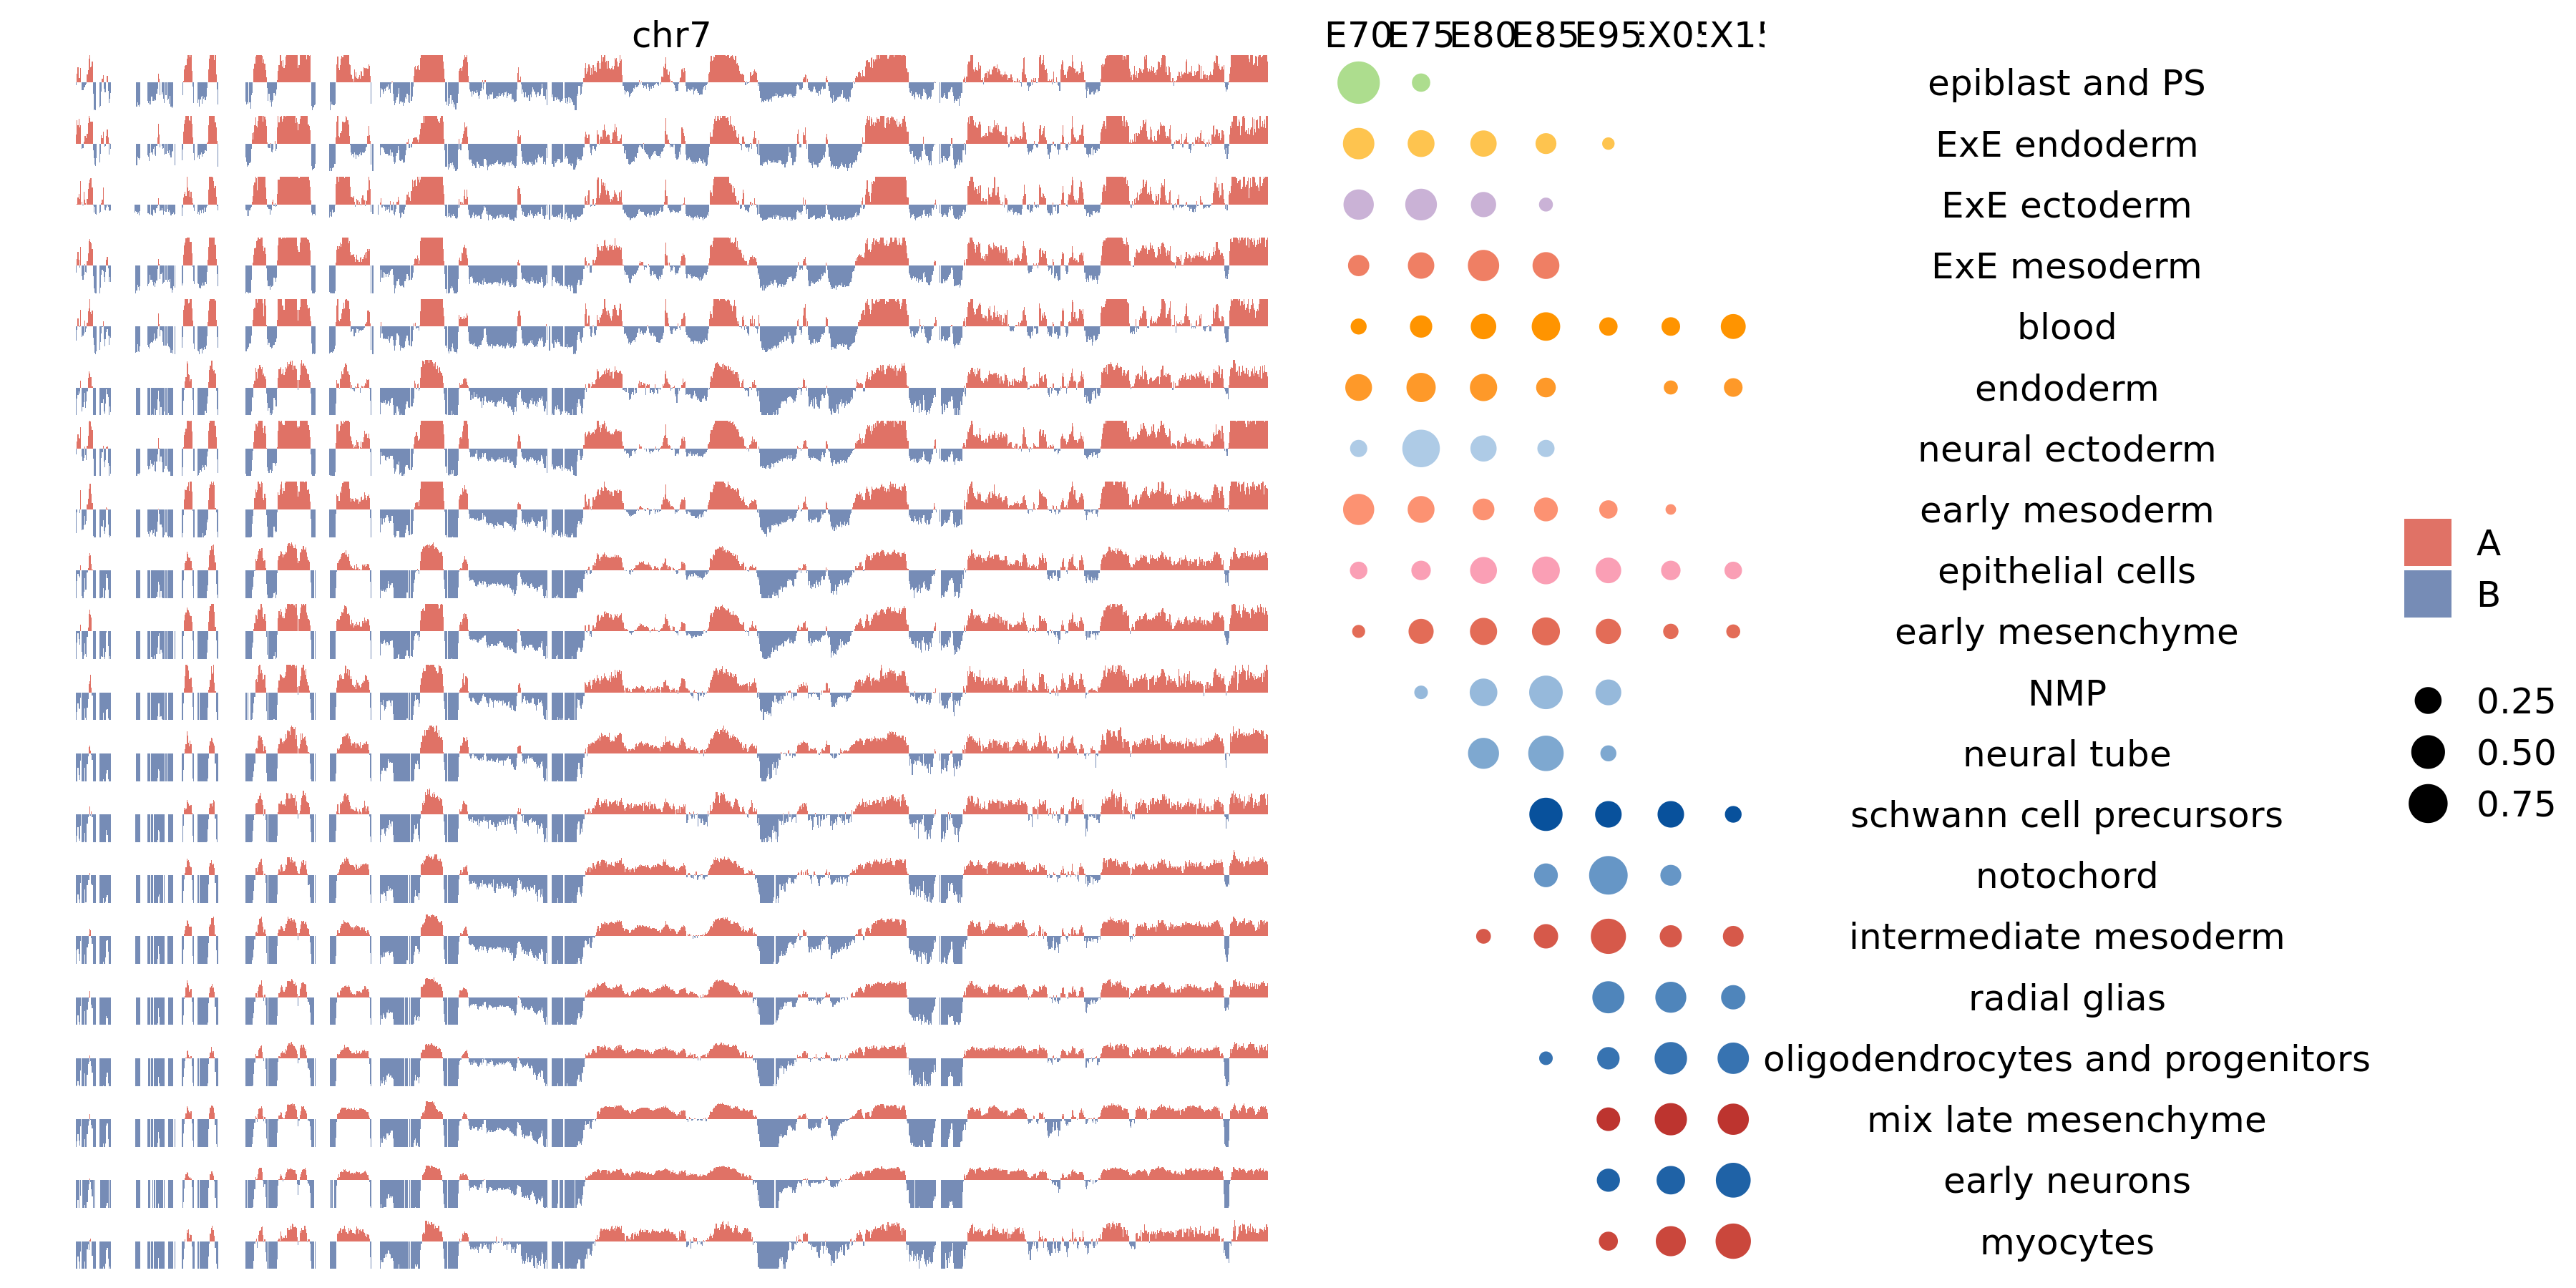

In [122]:
options(repr.plot.width=12,repr.plot.height=6,repr.plot.res=300)
(q+ theme(panel.spacing = unit(0, "lines")) + theme(strip.background = element_blank(),strip.text.y = element_blank())| p+ theme(panel.spacing = unit(0, "lines")) ) + 
    plot_layout(widths = c(3, 1),guides = "collect")

In [123]:
((q+ theme(panel.spacing = unit(0, "lines")) + theme(strip.background = element_blank(),strip.text.y = element_blank())| p+ theme(panel.spacing = unit(0, "lines")) ) + 
    plot_layout(widths = c(3, 1),guides = "collect")) %>% 
    ggsave(filename = "compartment.pdf",width = 12,height=6)

In [125]:
q <- combine %>% filter(chrom=="chr7",start > 60000000, start < 85000000,lineage != "mitosis") %>% na.omit() %>%  mutate(E1 = ifelse(E1>1,1,E1), E1 = ifelse(E1<(-1),-1,E1)) %>% ggplot(aes(x=start,y=E1,fill = compartment))  + 
        geom_bar(stat="identity", width = 100000)+ scale_fill_manual(values=c("#e07266","#768cb6")) + facet_grid(lineage~chrom) + 
      theme_classic()
q <-  pubReady(q) + theme(legend.position="left")
q <- q + theme(panel.spacing = unit(0, "lines"))
q%>%   ggsave(filename = "compartment_zoom.pdf",width = 12,height=6)

In [59]:
celltype_orders = c("early_mesenchyme","epithelial_cells","endoderm","neural_tube","NMP","intermediate_mesoderm","radial_glias",
                  "notochord", "schwann_cell_precursors","early_mesoderm","ExE_mesoderm","neural_ectoderm","epiblast_and_PS",
                  "blood","mix_late_mesenchyme","oligodendrocytes_and_progenitors","early_neurons","myocytes","ExE_endoderm","ExE_ectoderm")

In [68]:
# compartment correlation
left <- combine%>%  na.omit()%>% select(chrom,start,E1,lineage) %>% spread(lineage,E1) %>% na.omit() %>% 
                            select(-chrom,-start) %>% ggcorr()
left <- left$data
right <- left %>% select(y,x,coefficient,label)
names(right) <- c("x","y","coefficient","label")
full <- rbind(left,right) %>% select(-label)
corMat = full %>% spread(y,coefficient) %>% column_to_rownames("x")
corMat[is.na(corMat)] <- 1
distxy <- dist(corMat)
hc <- hclust(distxy)
dend <- as.dendrogram(hc)


left <- combine%>%  na.omit()%>% select(chrom,start,E1,lineage) %>% spread(lineage,E1) %>% na.omit() %>% 
                            select(-chrom,-start) %>% ggcorr()
left <- left$data
right <- left %>% select(y,x,coefficient,label)
names(right) <- c("x","y","coefficient","label")
full <- rbind(left,right) %>% select(-label)
corMat = full %>% spread(y,coefficient) %>% column_to_rownames("x")
corMat[is.na(corMat)] <- 1
distxy <- dist(corMat)
hc <- hclust(distxy)
dend <- as.dendrogram(hc)

options(repr.plot.width=6,repr.plot.height=4,repr.plot.res=200)

library(circlize)
col_fun <- colorRamp2(seq(from = 0.7,to=1,length.out = 7), c("#ffffcc","#ffeda0","#fed976","#feb24c","#fd8d3c","#fc4e2a","#e31a1c"))
p <- Heatmap(corMat[str_replace_all(celltype_orders,pattern = " ","_"),str_replace_all(celltype_orders,pattern = " ","_")]
             ,col = col_fun,cluster_columns = TRUE,cluster_rows = FALSE,
        column_dend_reorder =TRUE,
       heatmap_legend_param = list(title = "PCC"),
       #cell_fun = function(j, i, x, y, w, h, col) { # add text to each grid
       #     grid.text(substr(as.character(corMat[i, j]),start = 1,stop = 4), x, y)
       #},
        show_column_names = FALSE,
        column_names_rot = -45
)
draw(p)

Warning message:
“The input is a data frame, convert it to a matrix.”


In [70]:
pdf(paste0("compartment_correlation_heatmap.pdf"), width = 6, height = 4)
draw(p)
dev.off()

png 
  2

In [45]:
str_replace_all(celltype_orders,pattern = " ","_")

[1] "epiblast_and_PS"                  "ExE_ectoderm"                    
 [3] "ExE_endoderm"                     "neural_ectoderm"                 
 [5] "early_mesoderm"                   "endoderm"                        
 [7] "ExE_mesoderm"                     "early_mesenchyme"                
 [9] "neural_tube"                      "NMP"                             
[11] "epithelial_cells"                 "blood"                           
[13] "notochord"                        "schwann_cell_precursors"         
[15] "intermediate_mesoderm"            "radial_glias"                    
[17] "oligodendrocytes_and_progenitors" "mix_late_mesenchyme"             
[19] "early_neurons"                    "myocytes"

In [71]:
# keep compartment called in all types, 1.20 % of bins removed
combine %>% select(-weight,-E1,-E2,-E3) %>% spread(lineage,compartment) %>% dim()
combine %>% select(-weight,-E1,-E2,-E3) %>% spread(lineage,compartment) %>% na.omit() %>% dim()

[1] 23574    23

[1] 23329    23

In [74]:
library(ggpubr)
countAB_celltype <- combine %>% select(-weight,-E1,-E2,-E3) %>% spread(lineage,compartment) %>% na.omit() %>% 
    gather(celltype,compartment,-chrom,-start,-end) %>%
    group_by(chrom,start,end,compartment) %>% summarise(count = n()) %>% spread(compartment,count)
countAB_celltype[is.na(countAB_celltype)] <- 0

`summarise()` has grouped output by 'chrom', 'start', 'end'. You can override using the `.groups` argument.


Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


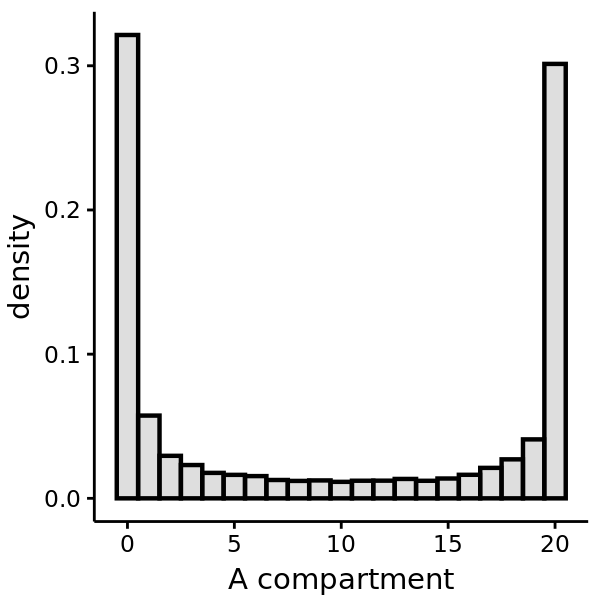

In [77]:
options(repr.plot.width=2,repr.plot.height=2,repr.plot.res=300)
# bins number is celltype number +1 
bins_num <- countAB_celltype %>% pull(A) %>% max() + 1
p <- countAB_celltype %>% gghistogram(x="A",y="..density..",bins = bins_num,fill="grey") + xlab("A compartment") +  theme_Publication()
p

In [78]:
p %>% ggsave(filename = "compp_distri.pdf",height = 1.5,width = 1.5,dpi = 300, units = "in") 

In [87]:
genes <- read_table("~/share/Data/public/ref_genome/mouse_ref/M23/raw_data/gene.bed",col_names = c("chr","start","end","id","name","strand")) %>% group_by(name) %>% slice(1)
resolution =1000000
Idents(hires) <- hires$celltype
meso_ecto_data <- getCpGDiffVocanoPlotData(hires,c("neural ectoderm"),c("early mesoderm"),genes,1000000,slot_cpg = "cpg")


── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  chr = col_character(),
  start = col_double(),
  end = col_double(),
  id = col_character(),
  name = col_character(),
  strand = col_character()
)

Joining, by = c("chr", "pos")
Joining, by = "name"


In [126]:
options(repr.plot.width=4,repr.plot.height=4,repr.plot.res=200)
meso_ecto_plot <- plotCpGDiffVocanoPlot(meso_ecto_data,"ectoderm vs. mesoderm",text_x_Pos = 0.1,scale_factor = 1)
a <- meso_ecto_plot + theme_classic() + ggtitle("") + xlab("Mean difference") + ylab("-log10(P-value)")

[1] "mean difference of CpG of all gene is 0.0162512252385657"


In [127]:
meso_ecto_data <- getCpGDiffVocanoPlotData(hires,c("early neurons"),c("mix late mesenchyme"),genes,1000000,slot_cpg = "cpg")
meso_ecto_plot <- plotCpGDiffVocanoPlot(meso_ecto_data,"neuron vs. mesenchyme",text_x_Pos = -0.1,scale_factor = 1)
b <- meso_ecto_plot + theme_classic()+ ggtitle("") + xlab("Mean difference") + ylab("-log10(P-value)")

Joining, by = c("chr", "pos")
Joining, by = "name"


[1] "mean difference of CpG of all gene is 0.030962824735253"


In [128]:
meso_ecto_data <- getCpGDiffVocanoPlotData(hires,c("ExE ectoderm"),c("ExE endoderm"),genes,1000000,slot_cpg = "cpg")
meso_ecto_plot <- plotCpGDiffVocanoPlot(meso_ecto_data,"Xecto vs. Xendo",text_x_Pos = 0.1,scale_factor = 1)
c <- meso_ecto_plot + theme_classic()+ ggtitle("") + xlab("Mean difference") + ylab("-log10(P-value)")

Joining, by = c("chr", "pos")
Joining, by = "name"


[1] "mean difference of CpG of all gene is 0.0162512252385657"


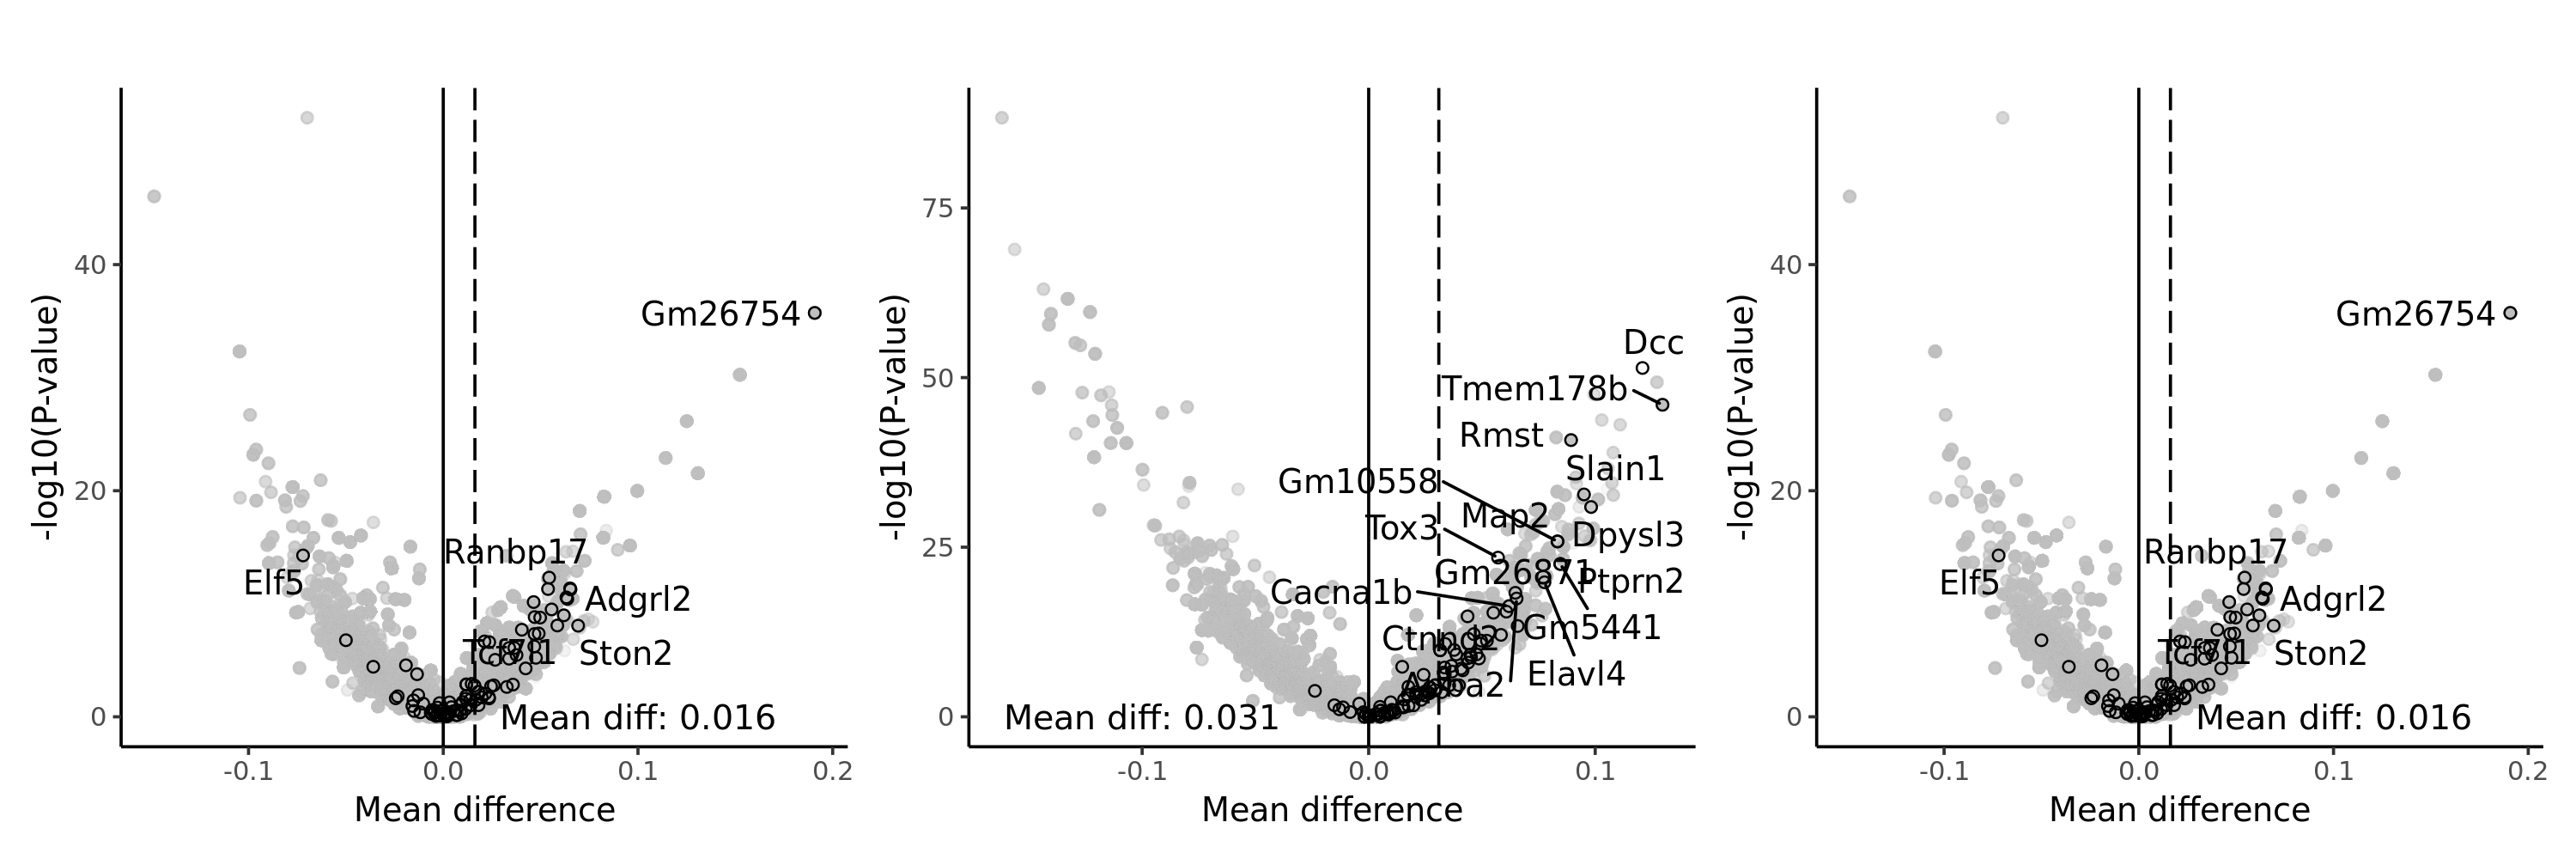

In [130]:
options(repr.plot.width=12,repr.plot.height=4,repr.plot.res=250)
a | b | c

# TAD

In [14]:
celltype_orders <- c("epiblast and PS","ExE endoderm","ExE ectoderm","ExE mesoderm","blood","endoderm","neural ectoderm",
                        "early mesoderm","epithelial cells","early mesenchyme","NMP","neural tube","schwann cell precursors",
                        "notochord","intermediate mesoderm","radial glias","oligodendrocytes and progenitors","mix late mesenchyme","early neurons","myocytes")


In [23]:
# load TAD boudary
TADs_all <- map(.x = celltype_orders %>% str_replace_all(" ","_"),.f = function(celltype_i) 
    {return(read_tsv(paste0("/shareb/zliu//analysis/hires_mouse_dev/figure3_related/pileup/processed//insulation/",celltype_i,".standardTAD.tsv")) %>% mutate(celltype = celltype_i) %>% suppressMessages())}
   ) %>% bind_rows()

In [24]:
TADs_all$celltype <- factor(TADs_all$celltype,levels = celltype_orders %>% str_replace_all(" ","_"))

In [53]:
TADs_all %>% filter(chrom %in% paste0("chr",seq(1,19))) -> TADs_all

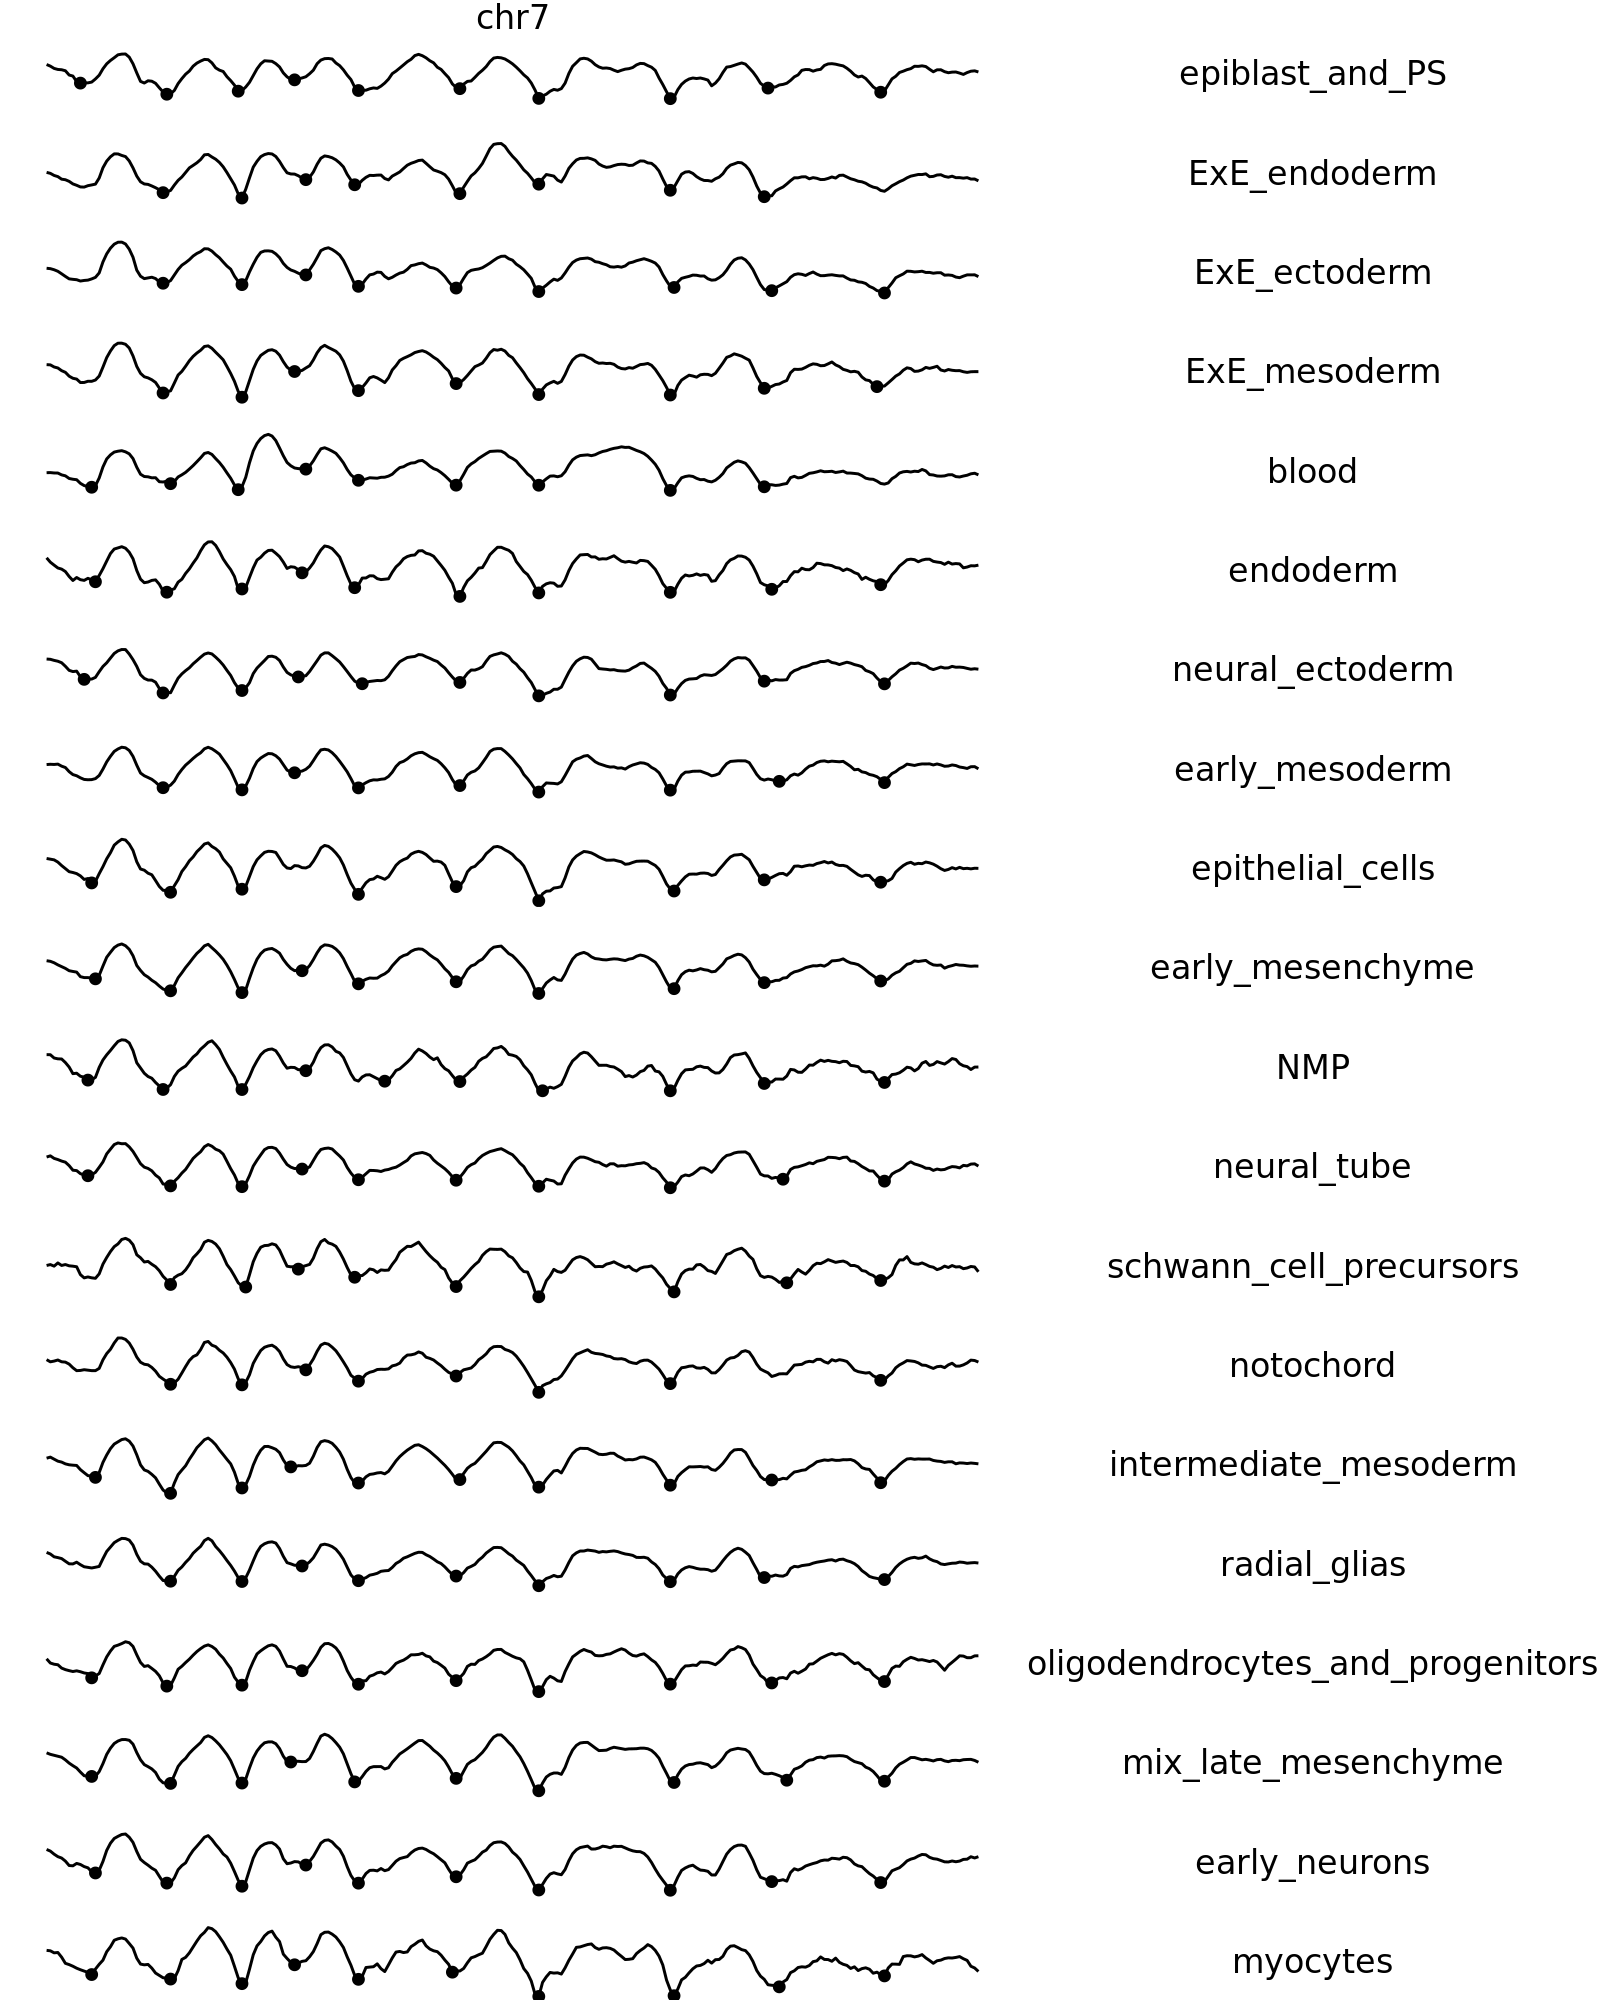

In [54]:
options(repr.plot.width=8,repr.plot.height=10,repr.plot.res=200)
temp <- TADs_all  %>% filter(chrom == "chr7") %>% filter(start > 65000000,start < 70000000)
p <- ggplot() + geom_line(data= temp,aes(x=start,y=log2_insulation_score_200000)) + #geom_point(data= temp,aes(x=start,y=boundary_strength_200000,color="red")) + 
    geom_point(data=temp %>% filter(is_boundary_200000 == TRUE,is_bad_bin == FALSE,boundary_strength_200000 > 0.5),aes(x=start,y=log2_insulation_score_200000)) + 
    facet_grid(celltype~chrom)
pubReady(p) + NoLegend()

In [55]:
left <- TADs_all %>% select(chrom,start,end,log2_insulation_score_500000,celltype) %>% spread(celltype,log2_insulation_score_500000) %>% na.omit() %>%
    select(- chrom,-start,-end) %>% 
    ggcorr()

left <- left$data
right <- left %>% select(y,x,coefficient,label)
names(right) <- c("x","y","coefficient","label")
full <- rbind(left,right) %>% select(-label)
corMat = full %>% spread(y,coefficient) %>% column_to_rownames("x")
corMat[is.na(corMat)] <- 1
distxy <- dist(corMat)
hc <- hclust(distxy)
dend <- as.dendrogram(hc)


options(repr.plot.width=6,repr.plot.height=4,repr.plot.res=200)

library(circlize)
col_fun <- colorRamp2(seq(from = 0.7,to=1,length.out = 7), c("#ffffcc","#ffeda0","#fed976","#feb24c","#fd8d3c","#fc4e2a","#e31a1c"))
p <- Heatmap(corMat,col = col_fun,cluster_columns = TRUE,cluster_rows = TRUE,
       row_dend_reorder =T,column_dend_reorder =T,
       heatmap_legend_param = list(title = "PCC"),
       #cell_fun = function(j, i, x, y, w, h, col) { # add text to each grid
       #     grid.text(substr(as.character(corMat[i, j]),start = 1,stop = 4), x, y)
       #},
        column_names_rot = -45,show_column_names = FALSE,
        show_row_dend = FALSE
        #add.expr = text(x = seq_along(labs), y = -0.2, srt = 45,labels = labs, xpd = TRUE)
)

Warning message:
“The input is a data frame, convert it to a matrix.”


In [56]:
pdf(paste0("insulation_correlation_heatmap.pdf"), width = 6.5, height = 4)
draw(p)
dev.off()

png 
  2